# Data Science & Machine Learning
Prof. Diógenes Justo

Grupo:


# **Atividade: Análise de RFM**
## *Eighty percent of our business comes from 20% of our customers. It costs 10 times less to sell to an existing customer than to find a new customer*
Historicamente, muitos negócios foram criados/desenvolvidos, entretanto, apenas alguns prosperaram por um grande período de tempo. Para estes negócios que prosperaram, podemos enumerar alguns motivos que os levaram a tal posição na história. 


1.   Produto/Serviço Inovador
2.   Acessibilidade em masse de produtos/serviços que antes eram caros/complexos de produzir
3.   Produto/Serviço Diferenciados/Únicos
4.   Status
5.   Fidelização de Clientes
.
.
.

Nesta atividade iremos fazer uma análise mais profundamente a ação de **Fidelização de Clientes**, estratégia utilizada extensivamente pelas áreas de marketing das empresas para direcionar campanhas/promoções para analisar o perfil de seus consumidores e direcionar corretamente campanhas que façam sentido a cada um dos perfis observados.  Utilizaremos um dataset para demonstrar a utilização da **técnica de RFM** (*Recency, Frequency e Monetary value*) para segmentação de perfil de clientes. 



# 0.0 - Bibliotecas

In [2]:
import datetime

import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt

from sklearn.cluster        import KMeans
from sklearn.preprocessing  import StandardScaler



## 0.1 - Carregando Dados e Renomeando Colunas

In [3]:
#Lendo carquivo csv e separando colunas através das vírgulas. 
fonte = "https://github.com/diogenesjusto/FIAP/blob/master/Gradua%C3%A7%C3%A3o/2021/S2/20210914/db_Exercicio_RFM.csv?raw=true"
df_raw = pd.read_csv(fonte, sep = ',')

#renomeando colunas para snakecase
ncoluna = ['id','customer_id', 'store_id', 'product_id', 'amount','date']
df_raw.columns = ncoluna

#criado copia de dataset original
df = df_raw.copy()
df.head()


,id,customer_id,store_id,product_id,amount,date
0,1,95595791691,409,196282,8.98,2020-01-01 00:14:41 UTC
1,2,8814812624,62,136956,0.00,2020-01-01 00:10:16 UTC
2,3,38552620634,408,329,9.98,2020-01-01 00:08:29 UTC
3,4,11561694614,405,104089,7.99,2020-01-01 00:06:10 UTC
4,5,1216506698,62,196180,11.96,2020-01-01 00:05:30 UTC


# 1.0 - Descrição dos Dados

In [4]:
# checar valores nulos
print(df.isnull().sum())
print('####################')
# checar dimensões
print(df.shape)
print('####################')
# checar distribuição dos dados numéricos contínuos
print(df.describe())
print('####################')
# checar data types
print(df.info())
print('####################')
# checar duplicados
df.duplicated().sum()

id             0
customer_id    0
store_id       0
product_id     0
amount         0
date           0
dtype: int64
####################
(92294, 6)
####################
                 id   customer_id      store_id     product_id        amount
count  92294.000000  9.229400e+04  92294.000000   92294.000000  92294.000000
mean   46147.500000  4.507167e+13    308.693404  161092.190023     14.412238
std    26643.127209  5.307587e+14    156.864919   49956.383433     24.768554
min        1.000000  1.910000e+02     56.000000     307.000000      0.000000
25%    23074.250000  4.843799e+09     72.000000  138236.000000      4.590000
50%    46147.500000  1.015791e+10    407.000000  188845.000000      8.900000
75%    69220.750000  5.083641e+10    410.000000  196055.000000     15.900000
max    92294.000000  6.298977e+15    417.000000  198458.000000   1548.030000
####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92294 entries, 0 to 92293
Data columns (total 6 columns):
 #   Colum

0

## 1.1 - Modificação do Tipo do Dado

In [5]:
## Modificando o data type IDs de número para texto
df['product_id'] = df['product_id'].astype(str)
df['store_id'] = df['store_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)
df['date'] = pd.to_datetime(df['date'])

In [6]:
#Verificando quantidade de lojas e produtos únicos
qtd_lojas = len(df.store_id.unique())
qtd_produtos = len(df.product_id.unique())
print('Neste dataset há {} lojas únicas e {} produtos únicos'.format(qtd_lojas,qtd_produtos))

Neste dataset há 32 lojas únicas e 629 produtos únicos


In [7]:
print('Compras realizadas entre {} e {}. São {} dias de dados.'.format(df['date'].min(),
                                    df['date'].max(), 
                                    (df['date'].max()-df['date'].min()).days
                                    )
)

Compras realizadas entre 2019-11-08 10:15:54+00:00 e 2020-01-01 00:14:41+00:00. São 53 dias de dados.


## 1.2 - Recencia
Neste KPI iremos avaliar o quão recente (em meses) o usuário realizou uma compra 

In [8]:
# recency (r) df - Definimos que será a diferença de meses da data mais recente 
# que o consumidor realizou uma compra de qualquer valor com a última data disponível no dataset.
df_r = df[['date','customer_id']].groupby('customer_id')['date'].agg('max').reset_index()
df_r.head()

,customer_id,date
0,10000432660,2019-12-16 13:17:38+00:00
1,10000825638,2019-12-31 16:17:51+00:00
2,10000966614,2019-11-29 17:27:48+00:00
3,10001156667,2019-12-31 19:17:24+00:00
4,10001329600,2019-11-24 17:49:22+00:00


In [9]:
# Data mais recente disponível no dataset
cur_time = df['date'].max()
# Funcao para diferença de meses
def month_diff(cur_time, ultima_data): 
    return 12 * (cur_time.year - ultima_data.year) + (cur_time.month - ultima_data.month)
# Calculo de Recência - Quantos meses da última compra
df_r['Recency'] = df_r['date'].apply(lambda x: month_diff(cur_time, x))

#Como utilizamos apenas um dataset de 2 meses, não iremos limitar temporalmente os dados.  Retiramos a coluna de data nesta etapa.
df_r = df_r.drop('date', axis = 1)
df_r.head()

,customer_id,Recency
0,10000432660,1
1,10000825638,1
2,10000966614,2
3,10001156667,1
4,10001329600,2


## 1.3 - Frequencia e Monetario
O KPI de frequencia indica a quantidade de transações concluída com sucesso pelo consumdor e o Monetário é a média gasta pelo consumidor durante o período estudado(2 meses).

In [10]:
# Frequency & Monetary(fm) 
data_fm  = df[['id','customer_id','amount']]

# Agregando valores de média de venda e quantidade de compras realizadas por consumidor 
data_fm  = data_fm .groupby('customer_id')[['id','amount']].agg({'id':'nunique', 'amount':'mean'}).reset_index()

data_fm  = data_fm .rename(columns = {'id':'Frequency', 'amount':'Monetary'})

# Arredondando valores decimais
data_fm .Monetary = data_fm .Monetary.round(2)
data_fm .head()

,customer_id,Frequency,Monetary
0,10000432660,1,3.99
1,10000825638,1,5.98
2,10000966614,1,39.90
3,10001156667,9,2.10
4,10001329600,1,5.98


In [11]:
# Criando uma tabela única com os valores finais de Recencia, Frequencia e Monetario, unindo as tabelas pelo id do consumidor. Caso haja um valor nulo, ele será preenchido com Zero.
df_rfm = df_r.merge(data_fm , on = 'customer_id', how = 'left')
df_rfm = df_rfm.fillna(0)
df_rfm.head()

,customer_id,Recency,Frequency,Monetary
0,10000432660,1,1,3.99
1,10000825638,1,1,5.98
2,10000966614,2,1,39.90
3,10001156667,1,9,2.10
4,10001329600,2,1,5.98


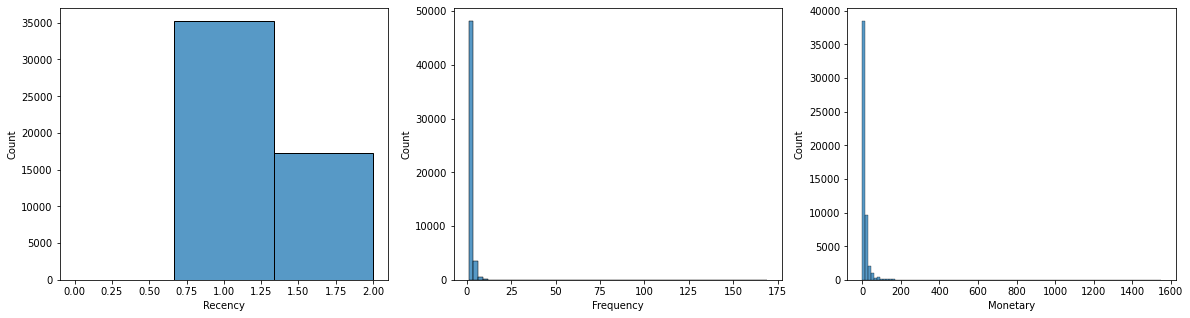

In [28]:
#Criando histograma dos kpis criados. 
#histograma de Recencia
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(df_rfm,  x='Recency', bins = 3)

#histograma de Frequencia
plt.subplot(1,3,2)
sns.histplot(df_rfm,  x='Frequency', bins = 60)

#histograma de Monetario
plt.subplot(1,3,3)
sns.histplot(df_rfm,  x='Monetary', bins = 100);

In [15]:
# Indicando as colunas alvos
feature_cols = ['Recency','Frequency','Monetary']
# Copiando os dados em um dataframe para aplicar a padronização dos dados. 
standardized_data = df_rfm.copy()

# Padronização utilizando standarscaler.Este método irá calcular a média e o 
# desvio padrão da coluna e irá aplicar em cada valor, deste modo teremos um dado normalizado para aplicar na próxima etapa
scaler = StandardScaler()

# Aplicando o StandardScaler na colunas alvos. 
scaler.fit(df_rfm[feature_cols])
standardized_features = scaler.transform(df_rfm[feature_cols])
standardized_data[feature_cols] = standardized_features

In [16]:
# fit K-means clustering on various Ks. Os centroides serão escolhidos de forma randomica para iniciar 
kmeans_kwargs = {"init" : "random", 'random_state': 75}
sse = []

# Aplicando o algoritmo em de 1 a 20 possíveis vizinhos
for k in range(1,21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(standardized_data[feature_cols])
    sse.append(kmeans.inertia_)

## 1.4 - Kmeans

Para avaliar os resultados obtidos da aplicação do algoritmo de Kmeans, utilizaremos o Elbow plot method. 
Este método consiste na aplicação dos resultados obtidos pelos consecutivas quantidades de vizinhos que o algoritmo foi testado. 
O K vizinhos ideais para dividir os dados treinados é indicado pela valor do eixo x onde houver a menor diferença da soma do erro quadratico.
Neste caso, consideraremos como 4 a quantidade ideal de k vizinhos. 

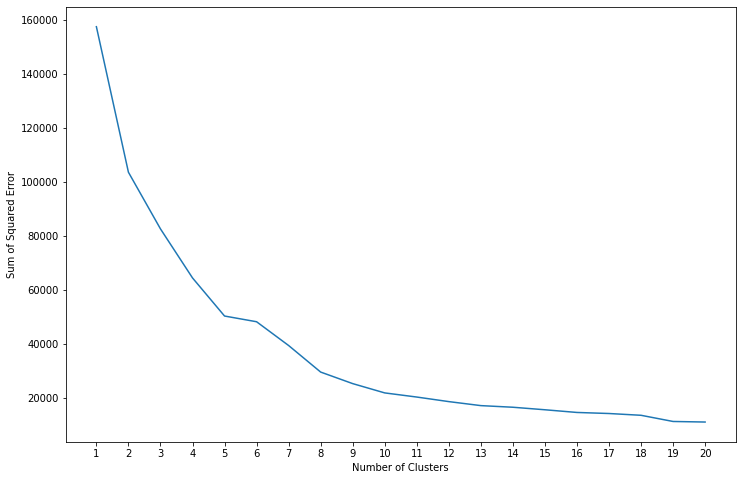

In [17]:

plt.figure(figsize = (12,8))
plt.plot(range(1,21), sse)
plt.xticks(range(1,21))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

In [18]:
# Aplicando o algoritmo de Kmeans com o valor de 4 cluster para segregar os clientes existentes no dataset. 
kmeans_kwargs = {"init" : "random", 'random_state': 75}
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(standardized_data[feature_cols])
df_rfm['cluster'] = kmeans.labels_
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,cluster
0,10000432660,1,1,3.99,3
1,10000825638,1,1,5.98,3
2,10000966614,2,1,39.90,2
3,10001156667,1,9,2.10,1
4,10001329600,2,1,5.98,2


In [19]:
teste_cluster = df_rfm.merge(df, how= 'inner', on = 'customer_id')
teste_cluster['ano_mes'] = teste_cluster['date'].apply(lambda x: (x.year).astype(str) + '-' + (x.month).astype(str))
teste_cluster['index'] = teste_cluster['ano_mes'].index

In [20]:
# Agrupando os centroides por cluster
centroid_df = df_rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary','customer_id']].agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary':'mean','customer_id':'nunique'}).reset_index()
centroid_df = centroid_df.rename(columns = {'customer_id':'NumBuyers'})
centroid_df

,cluster,Recency,Frequency,Monetary,NumBuyers
0,0,1.331899,1.459742,95.222372,1627
1,1,1.007502,5.663416,13.065094,3999
2,2,2.000000,1.312500,11.564403,16672
3,3,0.999834,1.503345,11.746058,30192


Com os dados observados no dataFrame **centroid_df** observamos a distribuição de cada valode de Recency, Frequency e Monetary por cada cluster. 
Uma **Frequencia** alta é um indicativo de que este grupo de consumidor é um comprador frequente da plataforma. 
Uma **Recencia** alta indica que este grupo de clientes estão sem comprar da plataforma há um tempo, dependendo da definição do negócio pode considerar como um grupo de retratores da marca/plataforma.
Um valor **Monetário** alto indica que este grupo de consumidores fazem compras de alto valor na plataforma. 

Deste modo podemos categorizar os 4 clusters do seguinte modo:
cluster 0 - 1627 clientes-> **Alta** Frequência, Recência normal e Valor Monetário normal -> ***Clientes de Alta Frequência***
cluster 1 - 3999 clientes-> Recência, Frequência e Monetário normal -> Clientes Ocasinais 
cluster 2 - 16672 clientes-> **Alta** Recência, Frequência normal e valor Monetário normal, segundo maior grupo -> ***Clientes Retratores da Marca***
cluster 3 - 30192 clientes-> Recência normal, Frequência normal e valor Monetário **Alto** , maior agrupamento-> ***Clientes TOP***








In [21]:
# Renomeando os clusters de acordo com a análise dos dados obtidos
centroid_df.pop('cluster')
cluster_names = ['Frequent Buyers','Casual Buyers','Churned Buyers','Top Buyers']
centroid_df['ClusterName'] = cluster_names
centroid_df

,Recency,Frequency,Monetary,NumBuyers,ClusterName
0,1.331899,1.459742,95.222372,1627,Frequent Buyers
1,1.007502,5.663416,13.065094,3999,Casual Buyers
2,2.000000,1.312500,11.564403,16672,Churned Buyers
3,0.999834,1.503345,11.746058,30192,Top Buyers


# 2.0 - Conclusão

Com os dados coletados, conseguimos realizar a segmentação de consumidores para possíveis campanhas de marketing melhores direcionadas. Por exemplo, criar uma promoção direcionada ao público de **Top Buyers** com um conjunto de produtos de alto valor final, mas com algum tipo de desconto ou criar outras promoções exclusivas para estes clientes que gastariam bastante. 
Para **Clientes Frequentes**, seria possível alguma ativação para cada X compras realizadas no site (clube de fidelidade). Para os **Clientes Casuais**, seria possível indicar promoções como o decréscimo de preço a partir da compra de valor tal, frete grátis  ou brindes para poder cativar o cliente e torna-lo um cliente frequente. 
Um ponto interessante é observar que o segundo maior grupo de clientes é o grupo de clientes que não fazem compra há mais de 2 meses. É certo que a amostra temporal de menos de 2 meses é pequeno, porém pode ser um indicativo que o site/negócio não está conseguindo ser atraente suficiente para manter os clientes realizarem suas compras, mesmo sendo de pequeno valor. Talvez algum teste A/B em formato de desconto para este público ou analisar o formato de mailing para estes clientes 'evoluirem' de cluster para compradores frequentes, verificar em quais plataformas o budget do marketing está sendo alocado e se este investimento está realmente retornando/convertendo o investimento em manter outra trazer novos clientes. 
São muitas as possibilidades de ações de marketing possíveis, sendo essas atividades sempre alinhadas com o objetivo da empresa. 

